In [19]:
### In[1]: Notebook Setup and Imports
import pandas as pd
import numpy as np
import os
import glob
import ast
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
print("Libraries imported successfully.")
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")


### In[2]: Configuration
# --- USER CONFIGURATION ---
REFERENCE_CSV_PATH = "/Users/ashkanhzdr/workspace/infectio-mesa/output/infectio_dVGFdF11/reference_metrics_for_M061M084M089_dVGFdF11_handpicked.csv"
EXPERIMENTS_ROOT_DIR = "/Users/ashkanhzdr/workspace/infectio-mesa/output/infectio_dVGFdF11/trina1_csv"
# --- END USER CONFIGURATION ---

METRICS_TO_PROCESS = [
    { "name": "Infected Count", "col": "inf-count-list" },
    { "name": "Plaque Area", "col": "area-list(um2)" },
    { "name": "Radial Velocity", "col": "radial-velocity-list(um/min)" }
]

### In[3]: Helper Function to Get Mean and Std
def get_stats_from_file(filepath, column_name):
    df = pd.read_csv(filepath)
    df.set_index('t', inplace=True)
    list_series = df[column_name].apply(ast.literal_eval)
    mean_series = list_series.apply(np.mean)
    std_series = list_series.apply(np.std)
    # This function MUST return a tuple of two items
    return mean_series, std_series

### In[4]: Load Reference Data and DEBUG
reference_data = {}
print(f"Loading reference data from: {REFERENCE_CSV_PATH}")
try:
    for metric in METRICS_TO_PROCESS:
        col_name = metric['col']
        # The value assigned here should be a 2-element tuple
        reference_data[col_name] = get_stats_from_file(REFERENCE_CSV_PATH, col_name)
    print("Reference data (mean and std) processed successfully.")
except Exception as e:
    print(f"AN ERROR OCCURRED IN CELL 4: {e}")

# --- !!!!! IMPORTANT DEBUGGING BLOCK !!!!! ---
print("\n--- DEBUG: INSPECTING 'reference_data' AFTER CREATION ---")
for k, v in reference_data.items():
    print(f"\nKey: '{k}'")
    print(f"  - Type of Value: {type(v)}")
    if isinstance(v, tuple):
        print(f"  - Length of tuple: {len(v)}")
        if len(v) == 2:
            print(f"  - Type of item 0: {type(v[0])}")
            print(f"  - Type of item 1: {type(v[1])}")
    else:
        print(f"  - !!! VALUE IS NOT A TUPLE, THIS IS LIKELY THE PROBLEM !!!")
print("--- DEBUG: END OF INSPECTION ---\n")
# --- !!!!! END OF DEBUGGING BLOCK !!!!! ---


### In[5]: Process All Experiments and Calculate Scores
experiment_files = glob.glob(os.path.join(EXPERIMENTS_ROOT_DIR, '*.csv'))
results = []
if not experiment_files:
    print(f"ERROR: No CSV files found in '{EXPERIMENTS_ROOT_DIR}'.")
else:
    print(f"Found {len(experiment_files)} experiments to process. Starting scoring...")
    for filepath in experiment_files:
        experiment_name = os.path.basename(filepath).replace('.csv', '')
        total_error_score = 0
        for metric in METRICS_TO_PROCESS:
            col_name = metric['col']
            if col_name not in reference_data: continue
            try:
                ref_mean, _ = reference_data[col_name]
                exp_mean, _ = get_stats_from_file(filepath, col_name)
                comparison_df = pd.DataFrame({'ref': ref_mean, 'exp': exp_mean}).dropna()
                if comparison_df.empty: continue
                scaler = MinMaxScaler()
                normalized_values = scaler.fit_transform(comparison_df)
                mae_score = mean_absolute_error(normalized_values[:, 0], normalized_values[:, 1])
                total_error_score += mae_score
            except Exception as e:
                print(f"ERROR during scoring for file {filepath} and metric {col_name}: {e}")
                # Break the inner loop and continue with the next file
                break
        results.append({'parameters': experiment_name, 'score': total_error_score})
    print("Scoring complete.")


### In[6]: Rank and Display Initial Results
if results:
    results_df = pd.DataFrame(results)
    ranked_results = results_df.sort_values(by='score', ascending=True).reset_index(drop=True)
else:
    ranked_results = pd.DataFrame(columns=['parameters', 'score'])

### In[7]: Parse Parameters into a Structured Table
def parse_parameters(filename):
    params = {}
    parts = filename.split('-')
    for part in parts:
        if '=' in part:
            key, value = part.split('=', 1)
            try: params[key] = float(value)
            except ValueError:
                try: params[key] = int(value)
                except ValueError: params[key] = value
    return params

if not ranked_results.empty:
    param_dicts = ranked_results['parameters'].apply(parse_parameters)
    params_df = pd.json_normalize(param_dicts)
    detailed_ranked_results = pd.concat([ranked_results, params_df], axis=1)
    print("\nParsed parameter table (Best performing):")
    display(detailed_ranked_results.head(15))
else:
    print("\nSkipping parameter parsing because no results were generated.")
    detailed_ranked_results = pd.DataFrame()




Libraries imported successfully.
Pandas version: 2.1.1
Numpy version: 1.25.2
Loading reference data from: /Users/ashkanhzdr/workspace/infectio-mesa/output/infectio_dVGFdF11/reference_metrics_for_M061M084M089_dVGFdF11_handpicked.csv
Reference data (mean and std) processed successfully.

--- DEBUG: INSPECTING 'reference_data' AFTER CREATION ---

Key: 'inf-count-list'
  - Type of Value: <class 'tuple'>
  - Length of tuple: 2
  - Type of item 0: <class 'pandas.core.series.Series'>
  - Type of item 1: <class 'pandas.core.series.Series'>

Key: 'area-list(um2)'
  - Type of Value: <class 'tuple'>
  - Length of tuple: 2
  - Type of item 0: <class 'pandas.core.series.Series'>
  - Type of item 1: <class 'pandas.core.series.Series'>

Key: 'radial-velocity-list(um/min)'
  - Type of Value: <class 'tuple'>
  - Length of tuple: 2
  - Type of item 0: <class 'pandas.core.series.Series'>
  - Type of item 1: <class 'pandas.core.series.Series'>
--- DEBUG: END OF INSPECTION ---

Found 72 experiments to proc

,parameters,score,randomwalk_speed,c2c_sigmoid_k,c2c_sigmoid_t0,c2c_sigmoid_tmid,c2c_radius_search,first_cell_lag
0,randomwalk_speed=0.3-c2c_sigmoid_k=0.01-c2c_si...,0.308101,0.30,0.01,24.0,64.0,30.0,72.0
1,randomwalk_speed=0.3-c2c_sigmoid_k=0.01-c2c_si...,0.308863,0.30,0.01,24.0,36.0,20.0,72.0
2,randomwalk_speed=0.3-c2c_sigmoid_k=0.01-c2c_si...,0.309740,0.30,0.01,6.0,64.0,25.0,72.0
3,randomwalk_speed=0.3-c2c_sigmoid_k=0.01-c2c_si...,0.310074,0.30,0.01,6.0,36.0,25.0,72.0
4,randomwalk_speed=0.5-c2c_sigmoid_k=0.01-c2c_si...,0.310286,0.50,0.01,6.0,36.0,30.0,72.0
5,randomwalk_speed=0.75-c2c_sigmoid_k=0.01-c2c_s...,0.311198,0.75,0.01,6.0,36.0,30.0,72.0
6,randomwalk_speed=0.3-c2c_sigmoid_k=0.01-c2c_si...,0.311395,0.30,0.01,24.0,64.0,25.0,36.0
7,randomwalk_speed=0.5-c2c_sigmoid_k=0.01-c2c_si...,0.311433,0.50,0.01,24.0,64.0,30.0,36.0
8,randomwalk_speed=0.5-c2c_sigmoid_k=0.01-c2c_si...,0.311539,0.50,0.01,6.0,36.0,30.0,36.0
9,randomwalk_speed=0.75-c2c_sigmoid_k=0.01-c2c_s...,0.312276,0.75,0.01,6.0,36.0,20.0,72.0


Configuration set to plot ranks from 1 to 5.

Generating 5 plot(s)...
/Users/ashkanhzdr/workspace/infectio-mesa/output/infectio_dVGFdF11/trina1_csv/randomwalk_speed=0.3-c2c_sigmoid_k=0.01-c2c_sigmoid_t0=24-c2c_sigmoid_tmid=64-c2c_radius_search=30-first_cell_lag=72.csv


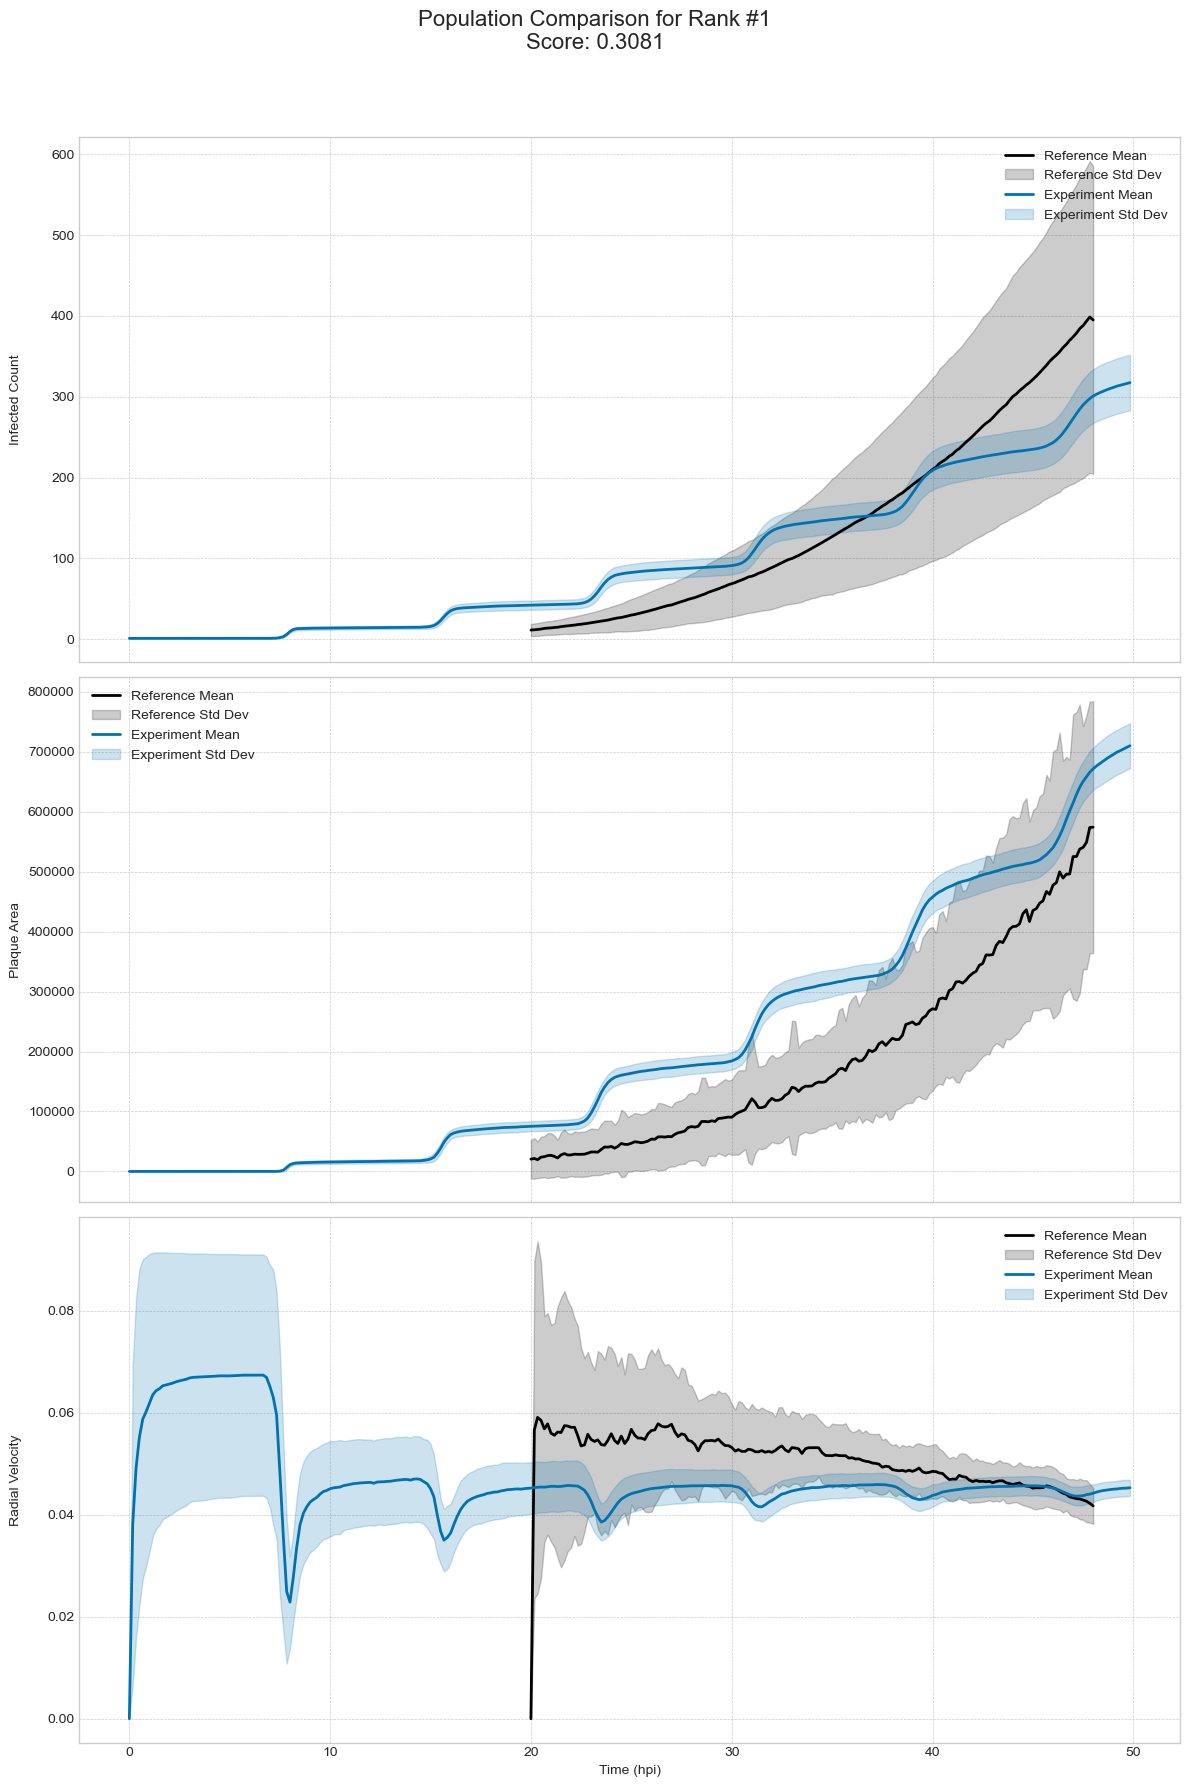

new Line: -------
/Users/ashkanhzdr/workspace/infectio-mesa/output/infectio_dVGFdF11/trina1_csv/randomwalk_speed=0.3-c2c_sigmoid_k=0.01-c2c_sigmoid_t0=24-c2c_sigmoid_tmid=36-c2c_radius_search=20-first_cell_lag=72.csv


KeyboardInterrupt: 

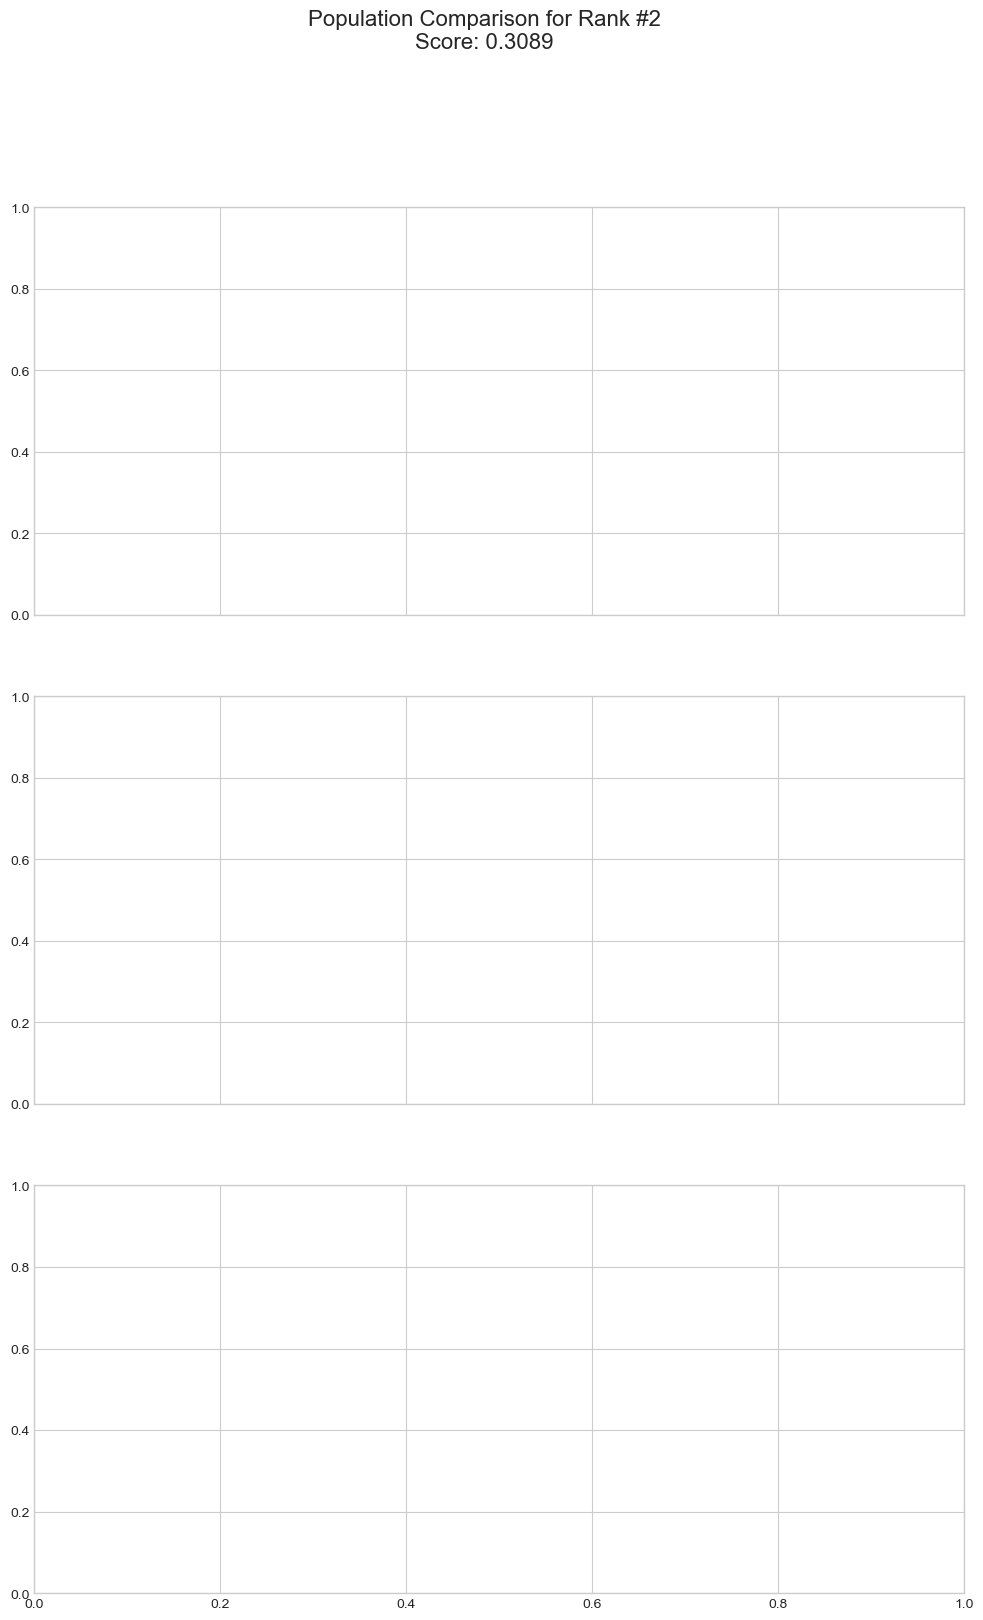

In [20]:
### In[8]: Plotting Configuration
START_RANK = 1
END_RANK = 5
print(f"Configuration set to plot ranks from {START_RANK} to {END_RANK}.")


### In[9]: Generate and Display Plots with Std Bands
if not detailed_ranked_results.empty:
    start_index = START_RANK - 1
    end_index = END_RANK
    if start_index < 0 or end_index > len(detailed_ranked_results):
        print(f"ERROR: Invalid rank range. Please choose between 1 and {len(detailed_ranked_results)}.")
    else:
        experiments_to_plot = detailed_ranked_results.iloc[start_index:end_index]
        print(f"\nGenerating {len(experiments_to_plot)} plot(s)...")
        for index, row in experiments_to_plot.iterrows():
            param_string = row['parameters']
            filepath = os.path.join(EXPERIMENTS_ROOT_DIR, param_string + '.csv')
            score = row['score']
            rank = index + 1
            fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 18), sharex=True)
            fig.suptitle(f"Population Comparison for Rank #{rank}\nScore: {score:.4f}", fontsize=16, y=0.99)
            print(filepath)
            for i, metric in enumerate(METRICS_TO_PROCESS):
                ax = axes[i]
                col_name = metric['col']
                try:
                    # The line that causes the error
                    ref_mean, ref_std = reference_data[col_name]
                    exp_mean, exp_std = get_stats_from_file(filepath, col_name)

                    ax.plot(ref_mean.index, ref_mean, color='black', linewidth=2, label='Reference Mean')
                    ax.fill_between(ref_mean.index, ref_mean - ref_std, ref_mean + ref_std, color='black', alpha=0.2, label='Reference Std Dev')
                    ax.plot(exp_mean.index, exp_mean, color='#0072B2', linewidth=2, label='Experiment Mean')
                    ax.fill_between(exp_mean.index, exp_mean - exp_std, exp_mean + exp_std, color='#0072B2', alpha=0.2, label='Experiment Std Dev')
                    ax.set_ylabel(metric['name'])
                    ax.legend()
                    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
                except Exception as e:
                    print(f"\n--- AN ERROR OCCURRED IN THE PLOTTING LOOP ---")
                    print(f"Attempting to plot for Rank {rank}, Metric '{col_name}'")
                    print(f"The error was: {e}")
                    # This will print the debug info again for the specific failing key
                    print(f"\nRe-inspecting the problematic value from the dictionary:")
                    problem_value = reference_data.get(col_name, "KEY NOT FOUND")
                    print(f"Value for key '{col_name}' is: {problem_value}")
                    print(f"Type of value is: {type(problem_value)}")
                    if isinstance(problem_value, tuple):
                        print(f"Length of tuple is: {len(problem_value)}")
                    print("--- END OF PLOTTING ERROR DEBUG ---")

            axes[-1].set_xlabel("Time (hpi)")
            fig.align_ylabels(axes)
            plt.tight_layout(rect=[0, 0, 1, 0.96])
            plt.show()
            print("new Line: -------")
        print("\nFinished generating plots.")
else:
    print("Skipping plot generation because no ranked results are available.")